# 📩 **Email spam classification using NLP**

## 📚 **Importing all necessary libraries**

In [1]:
import os
import pandas as pd

import email 
from email import policy
from email.parser import BytesParser
import re

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

## 📂 **Creating the dataframe**

In [2]:
# Path to the dataset folder
dataset_folder = 'dataset'

# Initialize an empty list to store the data
data = []

# Iterate through each subdirectory (spam, hard_ham, easy_ham)
for folder_name in os.listdir(dataset_folder):
    folder_path = os.path.join(dataset_folder, folder_name)
    
    # Determine the label based on the folder name
    if folder_name == 'spam':
        label = 'SPAM'
    else:
        label = 'HAM'
    
    # Iterate through each file in the subdirectory
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Read the content of the file
        with open(file_path, 'r', encoding='latin-1') as file:
            content = file.read()
        
        # Append the label and content to the data list
        data.append({'Label': label, 'Content': content})


# Create a DataFrame from the collected data
df_unshuffled = pd.DataFrame(data)
# Display the rows
print("Dataframe:\n\n",df_unshuffled)

df = df_unshuffled.sample(frac=1).reset_index(drop=True)

print("\nSchuffled Dataframe :\n\n",df)

Dataframe:

      Label                                            Content
0      HAM  From exmh-workers-admin@redhat.com  Thu Aug 22...
1      HAM  From Steve_Burt@cursor-system.com  Thu Aug 22 ...
2      HAM  From timc@2ubh.com  Thu Aug 22 13:52:59 2002\n...
3      HAM  From irregulars-admin@tb.tf  Thu Aug 22 14:23:...
4      HAM  From exmh-users-admin@redhat.com  Thu Aug 22 1...
...    ...                                                ...
4193  SPAM  From tba@insiq.us  Wed Dec  4 11:46:34 2002\nR...
4194  SPAM  Return-Path: <raye@yahoo.lv>\nReceived: from u...
4195  SPAM  From cweqx@dialix.oz.au  Tue Aug  6 11:03:54 2...
4196  SPAM  From ilug-admin@linux.ie  Wed Dec  4 11:52:36 ...
4197  SPAM  mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...

[4198 rows x 2 columns]

Schuffled Dataframe :

      Label                                            Content
0      HAM  From fork-admin@xent.com  Fri Aug 23 11:08:26 ...
1     SPAM  From OWNER-NOLIST-SGODAILY*JM**NETNOTEINC*-COM...
2      

## 🧹**Data cleaning** 

In [3]:
# Regex patterns to extract metadata
metadata_patterns = {
    'From': r"^From: (.*)$",
    'To': r"^To: (.*)$",
    'Subject': r"^Subject: (.*)$",
    'Date': r"^Date: (.*)$",
    
}

def parse_email(raw_email):
    # Parse email metadata
    metadata = {}
    for key, pattern in metadata_patterns.items():
        match = re.search(pattern, raw_email, re.MULTILINE)
        if match:
            metadata[key] = match.group(1)

    # Extract email body
    email_body_start = raw_email.find('\n\n') + 2
    body = raw_email[email_body_start:]

    return metadata, body


# Replace 'Content' with the appropriate column name if it's different

# Apply the parse_email function to each row in the DataFrame
parsed_data = df['Content'].apply(parse_email)

# Create a new DataFrame from the parsed email data
parsed_df = pd.DataFrame(parsed_data.tolist(), columns=['Metadata', 'Body'])
parsed_df.head()

,Metadata,Body
0,"{'From': 'Tom <tomwhore@slack.net>', 'To': '""J...","On Thu, 22 Aug 2002, Joseph S. Barrera III wro..."
1,{'From': 'Lowest LD <greatoffers@sendgreatoffe...,<html>\n<head>\n<title>mailv06c.gif</title>\n<...
2,"{'From': 'Tom <tomwhore@slack.net>', 'To': 'Gr...","On Wed, 2 Oct 2002, Gregory Alan Bolcer wrote:..."
3,"{'From': 'ether@buttonpushers.com', 'To': '<sk...","<html><body>\n<p align=3D""left""><b><font size=..."
4,"{'From': '""Apryl Westfall"" <carpheads@runbox.c...",<HTML>\n<HEAD>\n</HEAD>\n<BODY>\n<FONT SIZE=3D...


In [4]:
# Remove the date from the body
parsed_df['Body'] = parsed_df['Body'].apply(lambda x: re.sub(r"^Date: .*", "", x, flags=re.MULTILINE))

parsed_df.head()

,Metadata,Body
0,"{'From': 'Tom <tomwhore@slack.net>', 'To': '""J...","On Thu, 22 Aug 2002, Joseph S. Barrera III wro..."
1,{'From': 'Lowest LD <greatoffers@sendgreatoffe...,<html>\n<head>\n<title>mailv06c.gif</title>\n<...
2,"{'From': 'Tom <tomwhore@slack.net>', 'To': 'Gr...","On Wed, 2 Oct 2002, Gregory Alan Bolcer wrote:..."
3,"{'From': 'ether@buttonpushers.com', 'To': '<sk...","<html><body>\n<p align=3D""left""><b><font size=..."
4,"{'From': '""Apryl Westfall"" <carpheads@runbox.c...",<HTML>\n<HEAD>\n</HEAD>\n<BODY>\n<FONT SIZE=3D...


In [5]:

def remove_special_characters(text):
    # Define a regular expression pattern to match special characters
    pattern = r'[^a-zA-Z0-9\s]'  # Matches any character that is not a letter, digit, or whitespace

    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text


def parse_email_body(body):
    # Remove HTML tags
    body = re.sub(r'<[^>]+>', '', body)
    body = re.sub(r'nbsp', '',body)
    # Remove URLs
    body = re.sub(r'http\S+', '', body)
    # Remove special characters and escape sequences
    body = remove_special_characters(body)
    
    return body.strip()

# Apply the parse_email_body function to the 'Body' column of parsed_df
parsed_df['Body'] = parsed_df['Body'].apply(parse_email_body)
parsed_df.head()

,Metadata,Body
0,"{'From': 'Tom <tomwhore@slack.net>', 'To': '""J...",On Thu 22 Aug 2002 Joseph S Barrera III wrote\...
1,{'From': 'Lowest LD <greatoffers@sendgreatoffe...,mailv06cgif\n\n\n\n\n \n \n \n \n \n ...
2,"{'From': 'Tom <tomwhore@slack.net>', 'To': 'Gr...",On Wed 2 Oct 2002 Gregory Alan Bolcer wrote\nE...
3,"{'From': 'ether@buttonpushers.com', 'To': '<sk...",Lose weight while building lean muscle mass\na...
4,"{'From': '""Apryl Westfall"" <carpheads@runbox.c...",A man endowed with a 78 hammer is simply\n bet...


In [6]:
# Define a function to extract the main body of the email

def extract_main_body(body):
    # Split the body by lines
    lines = body.split('\n')
    main_body_lines = []
    for line in lines:
        if not re.match(r'^[-]+\s*$', line) and not re.match(r'^------------------', line) and not re.match(r'^\s*Yahoo! Groups Sponsor', line) and not re.match(r'^Your use of Yahoo! Groups is subject to', line):
            main_body_lines.append(line)
    # Join the remaining lines to form the main body
    main_body = '\n'.join(main_body_lines)
    return main_body.strip()

# Apply the extract_main_body function to the 'Body' column of parsed_df
parsed_df['Body'] = parsed_df['Body'].apply(extract_main_body)


parsed_df.head()

,Metadata,Body
0,"{'From': 'Tom <tomwhore@slack.net>', 'To': '""J...",On Thu 22 Aug 2002 Joseph S Barrera III wrote\...
1,{'From': 'Lowest LD <greatoffers@sendgreatoffe...,mailv06cgif\n\n\n\n\n \n \n \n \n \n ...
2,"{'From': 'Tom <tomwhore@slack.net>', 'To': 'Gr...",On Wed 2 Oct 2002 Gregory Alan Bolcer wrote\nE...
3,"{'From': 'ether@buttonpushers.com', 'To': '<sk...",Lose weight while building lean muscle mass\na...
4,"{'From': '""Apryl Westfall"" <carpheads@runbox.c...",A man endowed with a 78 hammer is simply\n bet...


In [7]:
# Concatenate the two DataFrames along the columns axis
merged_df = pd.concat([df, parsed_df], axis=1)
merged_df.head()

,Label,Content,Metadata,Body
0,HAM,From fork-admin@xent.com Fri Aug 23 11:08:26 ...,"{'From': 'Tom <tomwhore@slack.net>', 'To': '""J...",On Thu 22 Aug 2002 Joseph S Barrera III wrote\...
1,SPAM,From OWNER-NOLIST-SGODAILY*JM**NETNOTEINC*-COM...,{'From': 'Lowest LD <greatoffers@sendgreatoffe...,mailv06cgif\n\n\n\n\n \n \n \n \n \n ...
2,HAM,From fork-admin@xent.com Thu Oct 3 12:55:28 ...,"{'From': 'Tom <tomwhore@slack.net>', 'To': 'Gr...",On Wed 2 Oct 2002 Gregory Alan Bolcer wrote\nE...
3,SPAM,From ether@buttonpushers.com Mon Jun 24 17:48...,"{'From': 'ether@buttonpushers.com', 'To': '<sk...",Lose weight while building lean muscle mass\na...
4,SPAM,Received: from mail.bestfit2000.com ([63.72.22...,"{'From': '""Apryl Westfall"" <carpheads@runbox.c...",A man endowed with a 78 hammer is simply\n bet...


In [8]:
# Drop the 'Metadata' and 'Content' columns from the DataFrame
merged_df = merged_df.drop(columns=['Metadata', 'Content'])
merged_df.head()

,Label,Body
0,HAM,On Thu 22 Aug 2002 Joseph S Barrera III wrote\...
1,SPAM,mailv06cgif\n\n\n\n\n \n \n \n \n \n ...
2,HAM,On Wed 2 Oct 2002 Gregory Alan Bolcer wrote\nE...
3,SPAM,Lose weight while building lean muscle mass\na...
4,SPAM,A man endowed with a 78 hammer is simply\n bet...


In [9]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4198 entries, 0 to 4197
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4198 non-null   object
 1   Body    4198 non-null   object
dtypes: object(2)
memory usage: 65.7+ KB


## 📊 **Data Visualization**

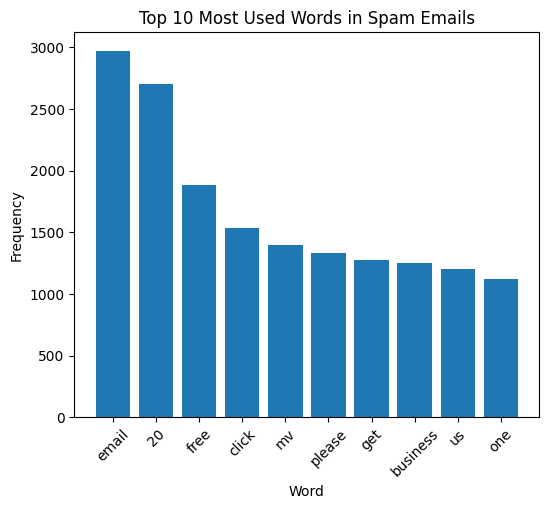

In [10]:
# Filter the DataFrame to include only spam emails
spam_df = merged_df[merged_df['Label'] == 'SPAM']

# Tokenize the text in the 'Body' column
tokens = []
for text in spam_df['Body']:
    tokens.extend(word_tokenize(text.lower()))  # Convert to lowercase



# Remove stop words
stop_words = set(stopwords.words('english'))
filtered_tokens = [token for token in tokens if token not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_tokens)

# Get most common words and their frequencies
top_words = word_counts.most_common(10)  

words, frequencies = zip(*top_words)

# Plot the most common words
plt.figure(figsize=(6, 5))
plt.bar(words, frequencies)
plt.title('Top 10 Most Used Words in Spam Emails')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Note :
- mv is short for Market Value

## 🔎 **Data Processing**

In [11]:
# Encoding the Label feature 
merged_df.loc[merged_df['Label'] == 'SPAM', 'Label'] = 0
merged_df.loc[merged_df['Label'] == 'HAM', 'Label'] = 1
merged_df.head()

,Label,Body
0,1,On Thu 22 Aug 2002 Joseph S Barrera III wrote\...
1,0,mailv06cgif\n\n\n\n\n \n \n \n \n \n ...
2,1,On Wed 2 Oct 2002 Gregory Alan Bolcer wrote\nE...
3,0,Lose weight while building lean muscle mass\na...
4,0,A man endowed with a 78 hammer is simply\n bet...


### Spliting the data into training and testing data

In [12]:
x = merged_df['Body']
y = merged_df['Label']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

### Transform the text data to feature vectors to be used as input

In [14]:
#Feature extraction
feature_extraction = TfidfVectorizer(min_df=1, stop_words='english', lowercase=True)
# Fit the vectorizer on the training data and transform both training and testing data
x_train_features = feature_extraction.fit_transform(x_train)
x_test_features = feature_extraction.transform(x_test)

In [15]:
# convert y_train and y_test values into integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [16]:
print(x_train)

964     Our Loan Packages Have\nNever Been More Attrac...
239     Interested in Renting or Selling your\nTimesha...
2387    TP A false positive really has to work hard th...
990     Have you checked your personal credit reports ...
108     Matthias Saou wrote\n OK Ill add this\n\nCool ...
                              ...                        
3444    use Perl Daily Headline Mailer\n\nTwo OSCON Li...
466     URL \n\n\nDrugs designed to prevent the compli...
3092    J  James Rogers  writes\n\n    J   They arent ...
3772    On Wed 28 Aug 2002 Matthew Cline wrote\n\n The...
860     WE NEED HELP  We are a 14 year old fortune 500...
Name: Body, Length: 3358, dtype: object


In [17]:
print(x_train_features)

  (0, 4923)	0.21971268394443155
  (0, 45337)	0.14583725846863532
  (0, 26660)	0.08430745664597043
  (0, 56951)	0.08289766553934051
  (0, 17174)	0.12164020400592021
  (0, 20015)	0.14095575797918
  (0, 42043)	0.19582060119014785
  (0, 59457)	0.08967707396864617
  (0, 21469)	0.0757939859009624
  (0, 58551)	0.07064242250988789
  (0, 22934)	0.050508068165316874
  (0, 51825)	0.0959896044340256
  (0, 57209)	0.06394688970444574
  (0, 41743)	0.15491928022640875
  (0, 52867)	0.14363244285501411
  (0, 55223)	0.07937301241482349
  (0, 46229)	0.18049419096772668
  (0, 41115)	0.12045478242970671
  (0, 46989)	0.2412374196139206
  (0, 20366)	0.10326509516910715
  (0, 16459)	0.19592642025190704
  (0, 26212)	0.0619057671763317
  (0, 2169)	0.08949969380279067
  (0, 32463)	0.08136537280486865
  (0, 50210)	0.16690493820841507
  :	:
  (3357, 31819)	0.13665139434983192
  (3357, 57666)	0.16331591952358346
  (3357, 26041)	0.15762394044352812
  (3357, 41736)	0.1360174912499113
  (3357, 47834)	0.2436392634616252

## 🤖 **Model training**

#### **LogisticRegression**

In [18]:
mailModel = LogisticRegression()

In [19]:
mailModel.fit(x_train_features, y_train)

LogisticRegression()

#### **Naive Bayes**

In [20]:
# store data as a matrix
cv= CountVectorizer()

x_train_count=cv.fit_transform(x_train.values)
x_test_count =cv.transform(x_test.values)

x_test_count.toarray()
x_train_count.toarray()

bModel=MultinomialNB()
#train
bModel.fit(x_train_count,y_train)

MultinomialNB()

## 📍 **Evaluationg the model's accuracy**

#### **LogisticRegression**

In [21]:
# Training Accuracy
prediction_training_data = mailModel.predict(x_train_features)
accuracy_training_data = accuracy_score(y_train, prediction_training_data)
print(accuracy_training_data)

0.9764740917212626


In [22]:
# Testing Accuracy
prediction_test_data = mailModel.predict(x_test_features)
accuracy_training_data = accuracy_score(y_test, prediction_test_data)
print(accuracy_training_data)

0.975


#### **Naive Bayes**

In [23]:
# Training Accuracy
prediction_training_data = bModel.predict(x_train_count)
accuracy_training_data = accuracy_score(y_train, prediction_training_data)
print(accuracy_training_data)

0.9949374627754616


In [24]:
# Testing Accuracy
prediction_test_data = bModel.predict(x_test_count)
accuracy_test_data = accuracy_score(y_test, prediction_test_data)
print(accuracy_test_data)

0.9821428571428571


- Ensuring that the Naive Bayes model is not overfitting 

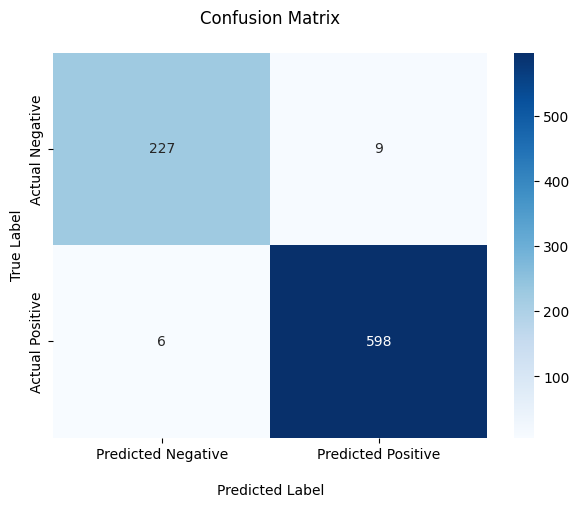

In [25]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, prediction_test_data)

# Visualize
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('\nPredicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix\n')
plt.show()

## ✅ **Model Testing**

#### **LogisticRegression**

In [26]:
y_pred = mailModel.predict(x_test_features)

num_rows = 10

# Combine predicted and actual values for comparison
results = zip(y_pred[:num_rows], y_test[:num_rows])

# Print predicted and actual values
print("------ Values ------")
print("Predicted | Actual")
for pred, actual in results:
    print(f"{pred}         | {actual}")

------ Values ------
Predicted | Actual
1         | 1
1         | 1
0         | 0
1         | 1
1         | 1
1         | 0
1         | 1
1         | 1
1         | 1
1         | 1


In [27]:
# Input an email you wanna test !
#Testing with Ham mail
input_your_email = ["Hi,I just wanted to remind you about our meeting tomorrow at 10 AM. Please let me know if you have any questions."]
input_data_features = feature_extraction.transform(input_your_email)
prediction = mailModel.predict(input_data_features)
print("Result :")
if(prediction==1):
    print('Ham mail')
else:
    print('Spam mail')

Result :
Ham mail


In [28]:
# Input an email you wanna test !
#Testing with Spam mail
input_your_email = ["You won a free car !!  Click the link : http.freecars.com "]
input_data_features = feature_extraction.transform(input_your_email)
prediction = mailModel.predict(input_data_features)
print("Result :")
if(prediction==1):
    print('Ham mail')
else:
    print('Spam mail')

Result :
Spam mail


#### **Naive Bayes**

In [29]:
# preTest HAM
email_ham =["Hi don't forget the meeting tomorrow 9am !"]
email_ham_count = cv.transform(email_ham)
prediction = bModel.predict(email_ham_count)
print("Result :")
# Check the prediction result
if prediction == 1:
    print(" Ham mail")
else:
    print(" Spam mail")

Result :
 Ham mail


In [30]:
# preTest SPAM
email_spam =["Please Join us and get 20 000$ to start your buisness !"]
email_spam_count=cv.transform(email_spam)
prediction = bModel.predict(email_spam_count)
print("Result :")
# Check the prediction result
if prediction == 1:
    print("Ham mail")
else:
    print("Spam mail")

Result :
Spam mail
